# Text Analytics INFO:
- Download entire subreddit history here:
- https://the-eye.eu/redarcs/
- save them in the folder "downloads/reddit-downloads"
- Then either do the 


# 1. Just some exploration

In [58]:
!pip install zstandard pandas jsonlines
!pip install textblob


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.3/626.3 kB 12.3 MB/s eta 0:00:00


### 1.1 just read a simple file

In [23]:
import zstandard
import os
import json
import pandas as pd
from datetime import datetime
import logging

# Set up logging
log = logging.getLogger("bot")
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler())


def read_and_decode(reader, chunk_size, max_window_size, previous_chunk=None, bytes_read=0):
    chunk = reader.read(chunk_size)
    bytes_read += chunk_size
    if previous_chunk is not None:
        chunk = previous_chunk + chunk
    try:
        return chunk.decode()
    except UnicodeDecodeError:
        if bytes_read > max_window_size:
            raise UnicodeError(f"Unable to decode frame after reading {bytes_read:,} bytes")
        log.info(f"Decoding error with {bytes_read:,} bytes, reading another chunk")
        return read_and_decode(reader, chunk_size, max_window_size, chunk, bytes_read)


def read_lines_zst(file_name):
    with open(file_name, 'rb') as file_handle:
        buffer = ''
        reader = zstandard.ZstdDecompressor(max_window_size=2**31).stream_reader(file_handle)
        while True:
            chunk = read_and_decode(reader, 2**27, (2**29) * 2)

            if not chunk:
                break
            lines = (buffer + chunk).split("\n")

            for line in lines[:-1]:
                yield line, file_handle.tell()

            buffer = lines[-1]

        reader.close()


if __name__ == "__main__":
    file_path = 'downloads/reddit-downloads/Northwestern_submissions.zst'
    file_size = os.stat(file_path).st_size
    file_lines = 0
    file_bytes_processed = 0
    bad_lines = 0

    # Store processed JSON objects in a list
    data = []

    for line, file_bytes_processed in read_lines_zst(file_path):
        try:
            obj = json.loads(line)  # Parse JSON line
            obj['created_datetime'] = datetime.utcfromtimestamp(int(obj['created_utc']))  # Add readable timestamp
            data.append(obj)  # Append to the list
        except (KeyError, json.JSONDecodeError) as err:
            bad_lines += 1
        file_lines += 1
        if file_lines % 100000 == 0:
            log.info(f"Processed {file_lines:,} lines, {bad_lines:,} bad lines. {file_bytes_processed / file_size * 100:.2f}% complete.")

    log.info(f"Complete: {file_lines:,} lines processed with {bad_lines:,} bad lines.")

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Specify the columns to keep
    columns_to_keep = [
        "title", "selftext", "score", "archived", "author", 
        "created_utc", "id", "media", "num_comments", 
        "subreddit", "created_datetime"
    ]

    # Filter the DataFrame to retain only these columns
    df = df[columns_to_keep]

    # Display first few rows
    # df.head()

    # Save to a CSV file for further analysis
    # df.to_csv('reddit_data.csv', index=False)


Complete: 15,175 lines processed with 0 bad lines.
Complete: 15,175 lines processed with 0 bad lines.
Complete: 15,175 lines processed with 0 bad lines.
Complete: 15,175 lines processed with 0 bad lines.
Complete: 15,175 lines processed with 0 bad lines.
Complete: 15,175 lines processed with 0 bad lines.


In [24]:
df.head()

,title,selftext,score,archived,author,created_utc,id,media,num_comments,subreddit,created_datetime
0,Whatever happened to nuonlinebooks?,,2,True,valtchanov,1231134298,7nf56,None,3,Northwestern,2009-01-05 05:44:58
1,Prosecutor Turns On Crusading Journalism School,,4,True,dustcircle,1263261289,aofy8,None,0,Northwestern,2010-01-12 01:54:49
2,Is this subreddit completely dead?,[removed],3,True,[deleted],1284696944,df1hz,None,6,Northwestern,2010-09-17 04:15:44
3,Resurrecting...,[deleted],1,True,[deleted],1286743871,dpff1,None,0,Northwestern,2010-10-10 20:51:11
4,Resurrecting...,,12,True,verymuchn0,1286744557,dpfj8,None,5,Northwestern,2010-10-10 21:02:37


In [25]:
# Display basic information about the DataFrame
print("Basic DataFrame Information:")
print(df.info())

# Number of rows and columns
print("\nShape of DataFrame (rows, columns):")
print(df.shape)

# Count of missing values per column
print("\nMissing values per column:")
print(df.isnull().sum())


Basic DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15175 entries, 0 to 15174
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   title             15175 non-null  object        
 1   selftext          15175 non-null  object        
 2   score             15175 non-null  int64         
 3   archived          14087 non-null  object        
 4   author            15175 non-null  object        
 5   created_utc       15175 non-null  object        
 6   id                15175 non-null  object        
 7   media             232 non-null    object        
 8   num_comments      15175 non-null  int64         
 9   subreddit         15175 non-null  object        
 10  created_datetime  15175 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 1.3+ MB
None

Shape of DataFrame (rows, columns):
(15175, 11)

Missing values per column:
title    

In [26]:
# First 5 values for each column
print("\nFirst 5 values for each column:")
for col in df.columns:
    print(f"\nColumn: {col}")
    print(df[col].head(20).to_list())


First 5 values for each column:

Column: title
['Whatever happened to nuonlinebooks?', 'Prosecutor Turns On Crusading Journalism School', 'Is this subreddit completely dead?', 'Resurrecting...', 'Resurrecting...', 'Northwestern Professor awarded Nobel Economics Prize ', 'TIL why the front doors of tech are so difficult to open', 'NU makes the headlines...ಠ_ಠ', 'NU Pranks', 'Evanston, IL: Scavenge Hunt. Any interest? (Crossposted by request). ', 'I am moving to Evanston for work at Northwestern. Does anyone have advice where or where not to live.', 'Free Food Watch', 'Any NU redditors that live in Bobb-McCulloch?', 'Best WCAS distros?', 'Any NU redditors attend the Chicago or DC Rallies to Restore Sanity and/or Fear?', 'Thanksgiving break', 'DAE...', 'Seen in the windows of Pancoe...', 'Best building to be in for the highest probability of survival in a medieval era style siege', 'Looking for a WCAS humanities distro for next quarter']

Column: selftext
['', '', '[removed]', '[deleted]

/var/folders/88/rkxmpw3j3nlddb7phwjzbx6r0000gn/T/ipykernel_97058/3034475546.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_posts['year'] = filtered_posts['created_datetime'].dt.year


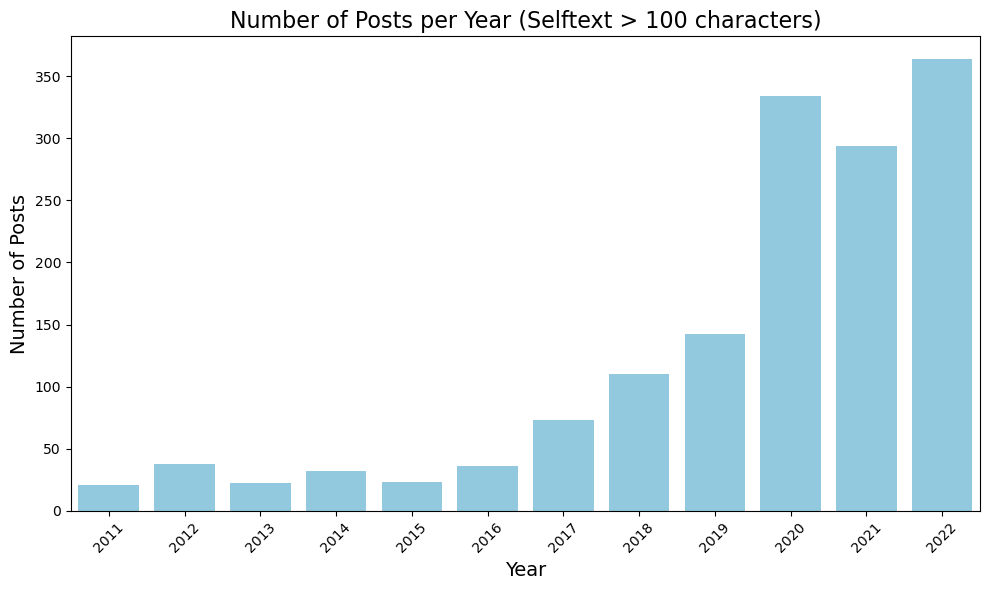

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Filter posts where 'selftext' is more than 100 characters
filtered_posts = df[df['selftext'].str.len() > 500]

# Step 2: Extract the year from the 'created_datetime' column
filtered_posts['year'] = filtered_posts['created_datetime'].dt.year

# Step 3: Count the number of posts per year
posts_per_year = filtered_posts['year'].value_counts().sort_index()

# Step 4: Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x=posts_per_year.index, y=posts_per_year.values, color='skyblue')

# Adding labels and title
plt.title('Number of Posts per Year (Selftext > 100 characters)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Posts', fontsize=14)

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [39]:
print(filtered_posts["selftext"].head(5).to_list())

["You probably got this email from the Dean of Students, but if you skipped over it...\n\nDear Students:\n\nThe City of Evanston today announced that, it does not plan to enforce more strictly a city ordinance prohibiting more than three unrelated persons living in the same apartment or house. The city has no plans to evict students from rental properties. The announcement came after Northwestern University administrators met with city officials about this planned action.\n\nWe appreciate the responsiveness of Evanston officials to the concerns raised by Northwestern students and administrators. At the same time, the University will oppose any efforts that target our students selectively using this ordinance. Doing so would be a disservice to our students, the University and the entire Evanston community.\n\nWe understand that the City was responding to complaints from other Evanston residents living near campus about issues related to noise, trash and unruly behavior and in an effort 

### 1.2 Read Data with Comments

In [41]:
if __name__ == "__main__":
    file_path = 'downloads/reddit-downloads/Northwestern_comments.zst'
    file_size = os.stat(file_path).st_size
    file_lines = 0
    file_bytes_processed = 0
    bad_lines = 0

    # Store processed JSON objects in a list
    data = []

    for line, file_bytes_processed in read_lines_zst(file_path):
        try:
            obj = json.loads(line)  # Parse JSON line
            obj['created_datetime'] = datetime.utcfromtimestamp(int(obj['created_utc']))  # Add readable timestamp
            data.append(obj)  # Append to the list
        except (KeyError, json.JSONDecodeError) as err:
            bad_lines += 1
        file_lines += 1
        if file_lines % 100000 == 0:
            log.info(f"Processed {file_lines:,} lines, {bad_lines:,} bad lines. {file_bytes_processed / file_size * 100:.2f}% complete.")

    log.info(f"Complete: {file_lines:,} lines processed with {bad_lines:,} bad lines.")

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Specify the columns to keep

    # Filter the DataFrame to retain only these columns
    #df = df[columns_to_keep]

Complete: 76,411 lines processed with 0 bad lines.
Complete: 76,411 lines processed with 0 bad lines.
Complete: 76,411 lines processed with 0 bad lines.
Complete: 76,411 lines processed with 0 bad lines.
Complete: 76,411 lines processed with 0 bad lines.
Complete: 76,411 lines processed with 0 bad lines.


In [42]:
# Display basic information about the DataFrame
print("Basic DataFrame Information:")
print(df.info())

# Number of rows and columns
print("\nShape of DataFrame (rows, columns):")
print(df.shape)

# Count of missing values per column
print("\nMissing values per column:")
print(df.isnull().sum())

Basic DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76411 entries, 0 to 76410
Data columns (total 77 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   score                            76411 non-null  int64         
 1   downs                            7538 non-null   float64       
 2   ups                              8781 non-null   float64       
 3   author                           76411 non-null  object        
 4   gilded                           76411 non-null  int64         
 5   created_utc                      76411 non-null  object        
 6   archived                         44652 non-null  object        
 7   edited                           76411 non-null  object        
 8   id                               76411 non-null  object        
 9   distinguished                    235 non-null    object        
 10  body                         

In [45]:
# Specify the columns to keep
columns_to_keep = [
    "score", "downs", "ups", "body", "author", 
    "created_utc", "id", "subreddit_id", 
    "parent_id", "created_datetime"
]

# Filter the DataFrame to retain only these columns
df = df[columns_to_keep]

In [46]:
df.head()

,score,downs,ups,body,author,created_utc,id,subreddit_id,parent_id,created_datetime
0,0,0.0,0.0,I've used it multiple times to find out what b...,valtchanov,1231134421,ae8q,t5_2qptt,t3_7nf56,2009-01-05 05:47:01
1,2,0.0,2.0,Don't they just get their info from the Norris...,dangson,1231136106,aepr,t5_2qptt,t1_ae8q,2009-01-05 06:15:06
2,1,0.0,1.0,Wow. I never knew that.\n\nI just checked and ...,valtchanov,1231197397,awk2,t5_2qptt,t1_aepr,2009-01-05 23:16:37
3,1,0.0,1.0,Yes.,TK-422,1285830973,c10y8hr,t5_2qptt,t3_df1hz,2010-09-30 07:16:13
4,1,0.0,1.0,definitely.,sirdrault,1286167637,c11b6p0,t5_2qptt,t3_df1hz,2010-10-04 04:47:17


/var/folders/88/rkxmpw3j3nlddb7phwjzbx6r0000gn/T/ipykernel_97058/3415831261.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_posts['year'] = filtered_posts['created_datetime'].dt.year


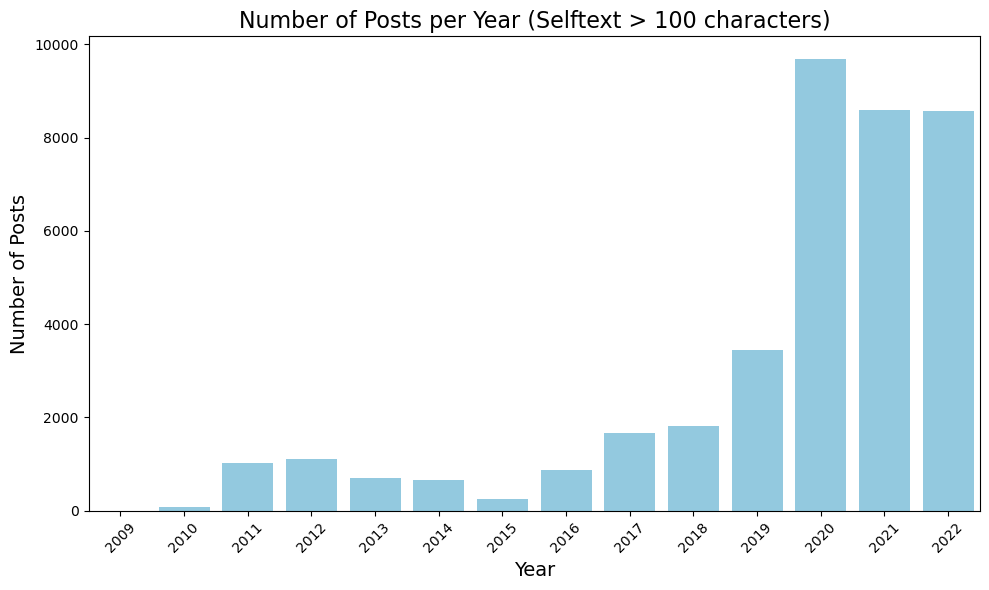

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Filter posts where 'selftext' is more than 100 characters
filtered_posts = df[df['body'].str.len() > 100]

# Step 2: Extract the year from the 'created_datetime' column
filtered_posts['year'] = filtered_posts['created_datetime'].dt.year

# Step 3: Count the number of posts per year
posts_per_year = filtered_posts['year'].value_counts().sort_index()

# Step 4: Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x=posts_per_year.index, y=posts_per_year.values, color='skyblue')

# Adding labels and title
plt.title('Number of Posts per Year (Selftext > 100 characters)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Posts', fontsize=14)

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 1.3 try to read Gradadmissions subreddit and filter it

In [50]:
if __name__ == "__main__":
    file_path = 'downloads/reddit-downloads/gradadmissions_submissions.zst'
    file_size = os.stat(file_path).st_size
    file_lines = 0
    file_bytes_processed = 0
    bad_lines = 0

    # Store processed JSON objects in a list
    data = []

    for line, file_bytes_processed in read_lines_zst(file_path):
        try:
            obj = json.loads(line)  # Parse JSON line
            obj['created_datetime'] = datetime.utcfromtimestamp(int(obj['created_utc']))  # Add readable timestamp
            data.append(obj)  # Append to the list
        except (KeyError, json.JSONDecodeError) as err:
            bad_lines += 1
        file_lines += 1
        if file_lines % 100000 == 0:
            log.info(f"Processed {file_lines:,} lines, {bad_lines:,} bad lines. {file_bytes_processed / file_size * 100:.2f}% complete.")

    log.info(f"Complete: {file_lines:,} lines processed with {bad_lines:,} bad lines.")

    # Create a DataFrame
    df = pd.DataFrame(data)

    # Specify the columns to keep
    columns_to_keep = [
        "title", "selftext", "score", "archived", "author", 
        "created_utc", "id", "media", "num_comments", 
        "subreddit", "created_datetime"
    ]

    # Filter the DataFrame to retain only these columns
    df = df[columns_to_keep]


Processed 100,000 lines, 0 bad lines. 94.28% complete.
Processed 100,000 lines, 0 bad lines. 94.28% complete.
Processed 100,000 lines, 0 bad lines. 94.28% complete.
Processed 100,000 lines, 0 bad lines. 94.28% complete.
Processed 100,000 lines, 0 bad lines. 94.28% complete.
Processed 100,000 lines, 0 bad lines. 94.28% complete.
Complete: 112,062 lines processed with 0 bad lines.
Complete: 112,062 lines processed with 0 bad lines.
Complete: 112,062 lines processed with 0 bad lines.
Complete: 112,062 lines processed with 0 bad lines.
Complete: 112,062 lines processed with 0 bad lines.
Complete: 112,062 lines processed with 0 bad lines.


/var/folders/88/rkxmpw3j3nlddb7phwjzbx6r0000gn/T/ipykernel_97058/2544544177.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_posts = df[df['selftext'].str.contains(keywords, flags=re.IGNORECASE, na=False)]
/var/folders/88/rkxmpw3j3nlddb7phwjzbx6r0000gn/T/ipykernel_97058/2544544177.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_posts['year'] = filtered_posts['created_datetime'].dt.year


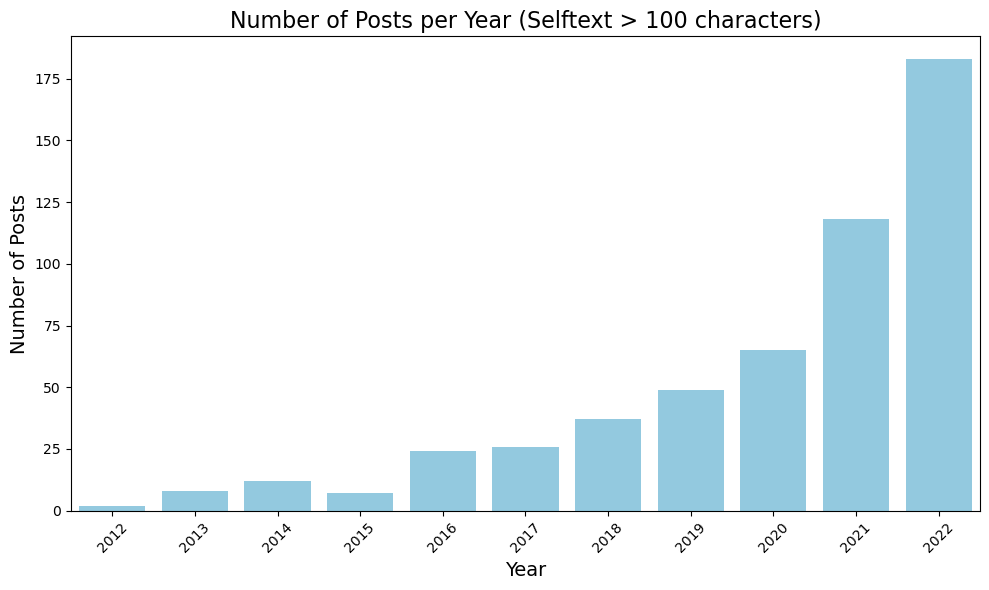

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

import re

# 1. Filter posts where 'selftext' contains the keywords
keywords = r'\b(northwestern|Northwestern|NU)\b'  # Regular expression for the keywords
filtered_posts = df[df['selftext'].str.contains(keywords, flags=re.IGNORECASE, na=False)]


# Step 2: Extract the year from the 'created_datetime' column
filtered_posts['year'] = filtered_posts['created_datetime'].dt.year

# Step 3: Count the number of posts per year
posts_per_year = filtered_posts['year'].value_counts().sort_index()

# Step 4: Plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x=posts_per_year.index, y=posts_per_year.values, color='skyblue')

# Adding labels and title
plt.title('Number of Posts per Year (Selftext > 100 characters)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Posts', fontsize=14)

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Actual Functions

### 2.1 Standard function to call and filter an entire subreddit history

Starting Reddit Data Analysis...
Starting Reddit Data Analysis...
Starting Reddit Data Analysis...
Starting Reddit Data Analysis...
Loading data from: downloads/reddit-downloads/ApplyingToCollege_submissions.zst
Loading data from: downloads/reddit-downloads/ApplyingToCollege_submissions.zst
Loading data from: downloads/reddit-downloads/ApplyingToCollege_submissions.zst
Loading data from: downloads/reddit-downloads/ApplyingToCollege_submissions.zst
Data loading complete with 620,963 rows and 0 bad lines.
Data loading complete with 620,963 rows and 0 bad lines.
Data loading complete with 620,963 rows and 0 bad lines.
Data loading complete with 620,963 rows and 0 bad lines.
Filtering data...
Filtering data...
Filtering data...
Filtering data...
Filtered data to 3,935 rows.
Filtered data to 3,935 rows.
Filtered data to 3,935 rows.
Filtered data to 3,935 rows.


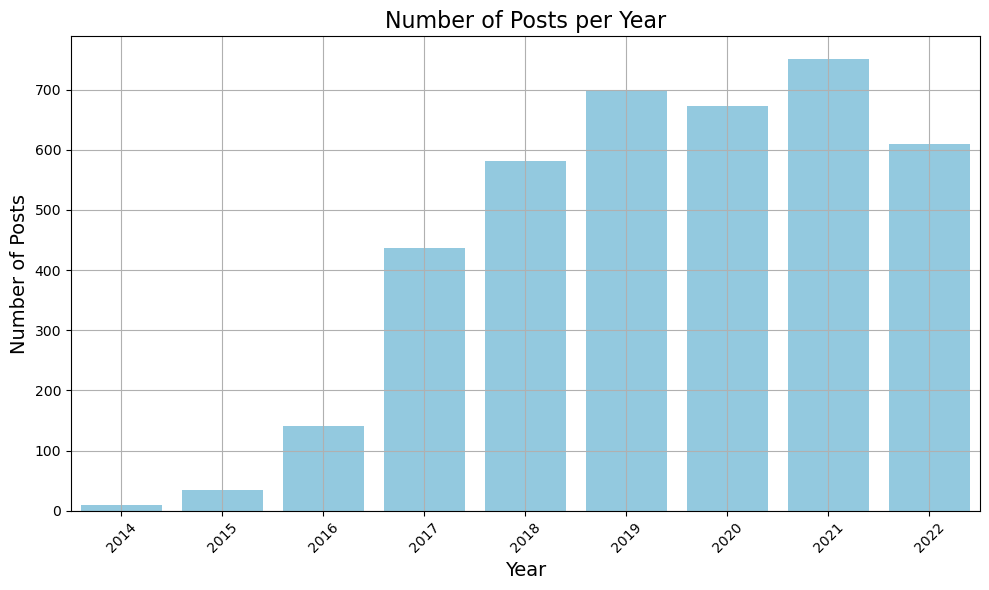

In [56]:
import zstandard
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import re
from datetime import datetime


# Set up logging
log = logging.getLogger("reddit_analysis")
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler())


# Function to decode zstandard files
def read_and_decode(reader, chunk_size, max_window_size, previous_chunk=None, bytes_read=0):
    chunk = reader.read(chunk_size)
    bytes_read += chunk_size
    if previous_chunk is not None:
        chunk = previous_chunk + chunk
    try:
        return chunk.decode()
    except UnicodeDecodeError:
        if bytes_read > max_window_size:
            raise UnicodeError(f"Unable to decode frame after reading {bytes_read:,} bytes")
        log.info(f"Decoding error with {bytes_read:,} bytes, reading another chunk")
        return read_and_decode(reader, chunk_size, max_window_size, chunk, bytes_read)


# Function to read lines from a zst file
def read_lines_zst(file_name):
    with open(file_name, 'rb') as file_handle:
        buffer = ''
        reader = zstandard.ZstdDecompressor(max_window_size=2**31).stream_reader(file_handle)
        while True:
            chunk = read_and_decode(reader, 2**27, (2**29) * 2)
            if not chunk:
                break
            lines = (buffer + chunk).split("\n")
            for line in lines[:-1]:
                yield line, file_handle.tell()
            buffer = lines[-1]
        reader.close()


# Function to process the raw file into a DataFrame
def load_reddit_data(file_path):
    log.info(f"Loading data from: {file_path}")
    file_size = os.stat(file_path).st_size
    data = []
    bad_lines = 0
    for line, _ in read_lines_zst(file_path):
        try:
            obj = json.loads(line)
            obj['created_datetime'] = datetime.utcfromtimestamp(int(obj['created_utc']))
            data.append(obj)
        except (KeyError, json.JSONDecodeError) as err:
            bad_lines += 1
    log.info(f"Data loading complete with {len(data):,} rows and {bad_lines:,} bad lines.")
    return pd.DataFrame(data)


# Function to filter and process the DataFrame
def filter_data(df, min_chars, keywords=None, start_year=None, end_year=None):
    log.info("Filtering data...")
    
    # Filter columns
    columns_to_keep = [
        "title", "selftext", "score", "archived", "author",
        "created_utc", "id", "media", "num_comments",
        "subreddit", "created_datetime"
    ]
    df = df[columns_to_keep]
    
    # Filter by text length
    df = df[df['selftext'].str.len() > min_chars]
    
    # Filter by keywords
    if keywords:
        keyword_regex = '|'.join([rf'\b{k}\b' for k in keywords])
        df = df[df['selftext'].str.contains(keyword_regex, flags=re.IGNORECASE, na=False)]
    
    # Filter by year range
    df['year'] = df['created_datetime'].dt.year
    if start_year:
        df = df[df['year'] >= start_year]
    if end_year:
        df = df[df['year'] <= end_year]
    
    log.info(f"Filtered data to {len(df):,} rows.")
    return df


# Function to plot the number of posts per year
def plot_posts_per_year(df):
    posts_per_year = df['year'].value_counts().sort_index()
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=posts_per_year.index, y=posts_per_year.values, color='skyblue')
    plt.title('Number of Posts per Year', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Number of Posts', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Main pipeline function
def analyze_reddit_data(file_path, min_chars, keywords=None, start_year=None, end_year=None):
    log.info("Starting Reddit Data Analysis...")
    
    # Step 1: Load data
    df = load_reddit_data(file_path)
    
    # Step 2: Filter data
    filtered_df = filter_data(df, min_chars, keywords, start_year, end_year)
    
    # Step 3: Plot data
    plot_posts_per_year(filtered_df)
    
    return filtered_df


# Example usage of the pipeline
if __name__ == "__main__":
    file_path = 'downloads/reddit-downloads/ApplyingToCollege_submissions.zst'
    min_chars = 100
    keywords = ["northwestern", "NU"]
    start_year = 2000
    end_year = 2024
    
    result_df = analyze_reddit_data(file_path, min_chars, keywords, start_year, end_year)
    # print(result_df.head())


### 2.2 function to read and filter posts and also get associated Comments

Starting Reddit Data Analysis...
Starting Reddit Data Analysis...
Starting Reddit Data Analysis...
Loading data from: downloads/reddit-downloads/Northwestern_submissions.zst
Loading data from: downloads/reddit-downloads/Northwestern_submissions.zst
Loading data from: downloads/reddit-downloads/Northwestern_submissions.zst
Data loading complete with 15,175 rows and 0 bad lines.
Data loading complete with 15,175 rows and 0 bad lines.
Data loading complete with 15,175 rows and 0 bad lines.
Filtering submissions...
Filtering submissions...
Filtering submissions...
Filtered submissions to 2,488 rows.
Filtered submissions to 2,488 rows.
Filtered submissions to 2,488 rows.
Filtering comments...
Filtering comments...
Filtering comments...
Loading data from: downloads/reddit-downloads/Northwestern_comments.zst
Loading data from: downloads/reddit-downloads/Northwestern_comments.zst
Loading data from: downloads/reddit-downloads/Northwestern_comments.zst
Data loading complete with 76,411 rows and 

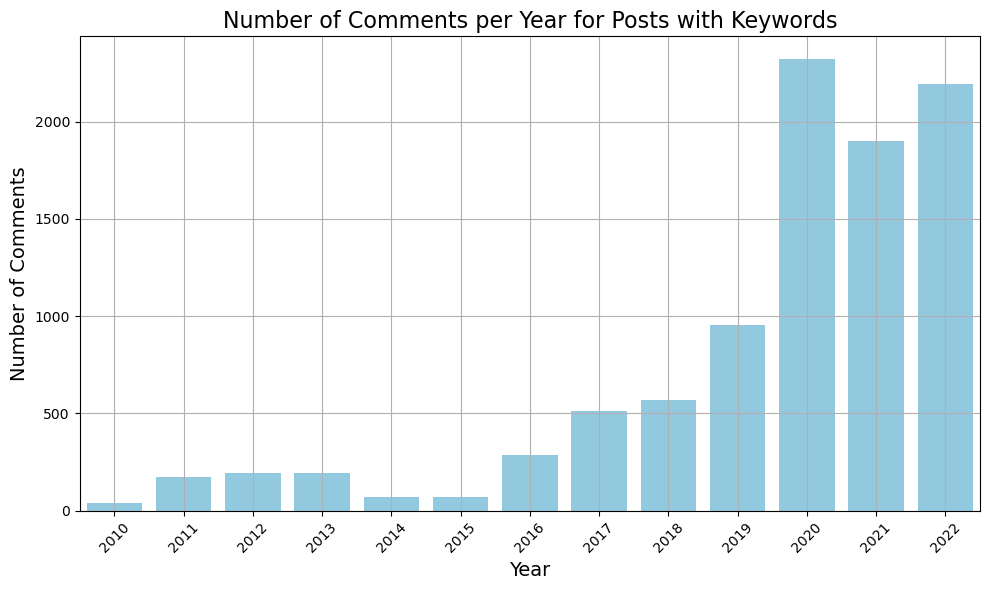

                                                title  \
22                              Advertising on campus   
26            How to find off campus housing... Halp?   
37                                       Who are you?   
42  Must-take-before-you-graduate courses at \r\nN...   
57                  Good news in the brothel law saga   

                                             selftext  score archived  \
22  Do you guys/gals think it would be worth our t...      2     True   
26  Hey /northwestern,\nSo I'm a sophomore, and th...      4     True   
37  Just trying to get a sense of who's on /r/Nort...     12     True   
42  Lets list the must-take-before-you-graduate-NU...      2      NaN   
57  You probably got this email from the Dean of S...      1      NaN   

                 author created_utc     id media  num_comments     subreddit  \
22            [deleted]  1290092514  e849o  None            16  Northwestern   
26              bjlange  1290408523  e9tdh  None          

In [54]:
import zstandard
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import re
from datetime import datetime


# Set up logging
log = logging.getLogger("reddit_analysis")
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler())


# Function to decode zstandard files
def read_and_decode(reader, chunk_size, max_window_size, previous_chunk=None, bytes_read=0):
    chunk = reader.read(chunk_size)
    bytes_read += chunk_size
    if previous_chunk is not None:
        chunk = previous_chunk + chunk
    try:
        return chunk.decode()
    except UnicodeDecodeError:
        if bytes_read > max_window_size:
            raise UnicodeError(f"Unable to decode frame after reading {bytes_read:,} bytes")
        log.info(f"Decoding error with {bytes_read:,} bytes, reading another chunk")
        return read_and_decode(reader, chunk_size, max_window_size, chunk, bytes_read)


# Function to read lines from a zst file
def read_lines_zst(file_name):
    with open(file_name, 'rb') as file_handle:
        buffer = ''
        reader = zstandard.ZstdDecompressor(max_window_size=2**31).stream_reader(file_handle)
        while True:
            chunk = read_and_decode(reader, 2**27, (2**29) * 2)
            if not chunk:
                break
            lines = (buffer + chunk).split("\n")
            for line in lines[:-1]:
                yield line, file_handle.tell()
            buffer = lines[-1]
        reader.close()


# Function to process the raw file into a DataFrame
def load_reddit_data(file_path):
    log.info(f"Loading data from: {file_path}")
    file_size = os.stat(file_path).st_size
    data = []
    bad_lines = 0
    for line, _ in read_lines_zst(file_path):
        try:
            obj = json.loads(line)
            obj['created_datetime'] = datetime.utcfromtimestamp(int(obj['created_utc']))
            data.append(obj)
        except (KeyError, json.JSONDecodeError) as err:
            bad_lines += 1
    log.info(f"Data loading complete with {len(data):,} rows and {bad_lines:,} bad lines.")
    return pd.DataFrame(data)


# Function to filter submissions
def filter_submissions(df, min_chars, keywords=None, start_year=None, end_year=None):
    log.info("Filtering submissions...")
    columns_to_keep = [
        "title", "selftext", "score", "archived", "author",
        "created_utc", "id", "media", "num_comments",
        "subreddit", "created_datetime"
    ]
    df = df[columns_to_keep]
    df = df[df['selftext'].str.len() > min_chars]
    if keywords:
        keyword_regex = '|'.join([rf'\b{k}\b' for k in keywords])
        df = df[df['selftext'].str.contains(keyword_regex, flags=re.IGNORECASE, na=False)]
    df['year'] = df['created_datetime'].dt.year
    if start_year:
        df = df[df['year'] >= start_year]
    if end_year:
        df = df[df['year'] <= end_year]
    log.info(f"Filtered submissions to {len(df):,} rows.")
    return df


# Function to filter comments
def filter_comments(comments_file, submission_ids):
    log.info("Filtering comments...")
    comments_df = load_reddit_data(comments_file)
    columns_to_keep = [
        "score", "downs", "ups", "body", "author",
        "created_utc", "id", "subreddit_id",
        "parent_id", "created_datetime"
    ]
    comments_df = comments_df[columns_to_keep]
    comments_df = comments_df[comments_df['parent_id'].str[3:].isin(submission_ids)]
    log.info(f"Filtered comments to {len(comments_df):,} rows.")
    return comments_df


# Function to plot the number of comments over time
def plot_comments_over_time(comments_df):
    comments_df['year'] = comments_df['created_datetime'].dt.year
    comments_per_year = comments_df['year'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=comments_per_year.index, y=comments_per_year.values, color='skyblue')
    plt.title('Number of Comments per Year for Posts with Keywords', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Number of Comments', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Main pipeline function
def analyze_reddit_data(file_path_submissions, file_path_comments, min_chars, keywords=None, start_year=None, end_year=None):
    log.info("Starting Reddit Data Analysis...")
    # Step 1: Load and filter submissions
    submissions_df = load_reddit_data(file_path_submissions)
    filtered_submissions = filter_submissions(submissions_df, min_chars, keywords, start_year, end_year)
    submission_ids = filtered_submissions['id'].tolist()
    
    # Step 2: Load and filter comments
    filtered_comments = filter_comments(file_path_comments, submission_ids)
    
    # Step 3: Plot data
    plot_comments_over_time(filtered_comments)
    
    return filtered_submissions, filtered_comments


# Example usage of the pipeline
if __name__ == "__main__":
    submissions_file = 'downloads/reddit-downloads/Northwestern_submissions.zst'
    comments_file = 'downloads/reddit-downloads/Northwestern_comments.zst'
    min_chars = 100
    keywords = ["northwestern", "NU"]
    start_year = 2000
    end_year = 2025
    
    submissions, comments = analyze_reddit_data(submissions_file, comments_file, min_chars, keywords, start_year, end_year)
    #print(submissions.head())
    #print(comments.head())


In [55]:
def display_example(submissions_df, comments_df):
    # Select an example submission ID
    example_id = submissions_df['id'].iloc[0]  # Get the first submission ID as an example
    log.info(f"Example Submission ID: {example_id}")
    
    # Retrieve the associated comments
    associated_comments = comments_df[comments_df['parent_id'].str[3:] == example_id]
    
    # Print the submission details
    print("\nExample Submission:")
    print(submissions_df[submissions_df['id'] == example_id].to_string(index=False))
    
    # Print the associated comments
    print("\nAssociated Comments:")
    print(associated_comments.to_string(index=False))

# Example usage of the display function
if __name__ == "__main__":
    # Ensure `submissions` and `comments` DataFrames are generated from the pipeline
    display_example(submissions, comments)


Example Submission ID: e849o
Example Submission ID: e849o
Example Submission ID: e849o



Example Submission:
                title                                                                                                                                                                                                                                                                                                                                                              selftext  score archived    author created_utc    id media  num_comments    subreddit    created_datetime  year
Advertising on campus Do you guys/gals think it would be worth our time to put up some fliers with the reddit alien and "/r/northwestern" to advertise the fact there is a Northwestern subreddit?\n\nedit:Here is a quick flier that I made in Word. Print it out and post it up!\nhttp://dl.dropbox.com/u/6103149/NU%20Reddit.docx\nhttps://rapidshare.com/files/431698661/NU_Reddit.docx      2     True [deleted]  1290092514 e849o  None            16 Northwestern 2010-11-18 15:01:54  2010

Associated C

### 1.3 Simple sentiment analysis pipeline (without comments)

/Users/jakobkuemmerle/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jakobkuemmerle/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


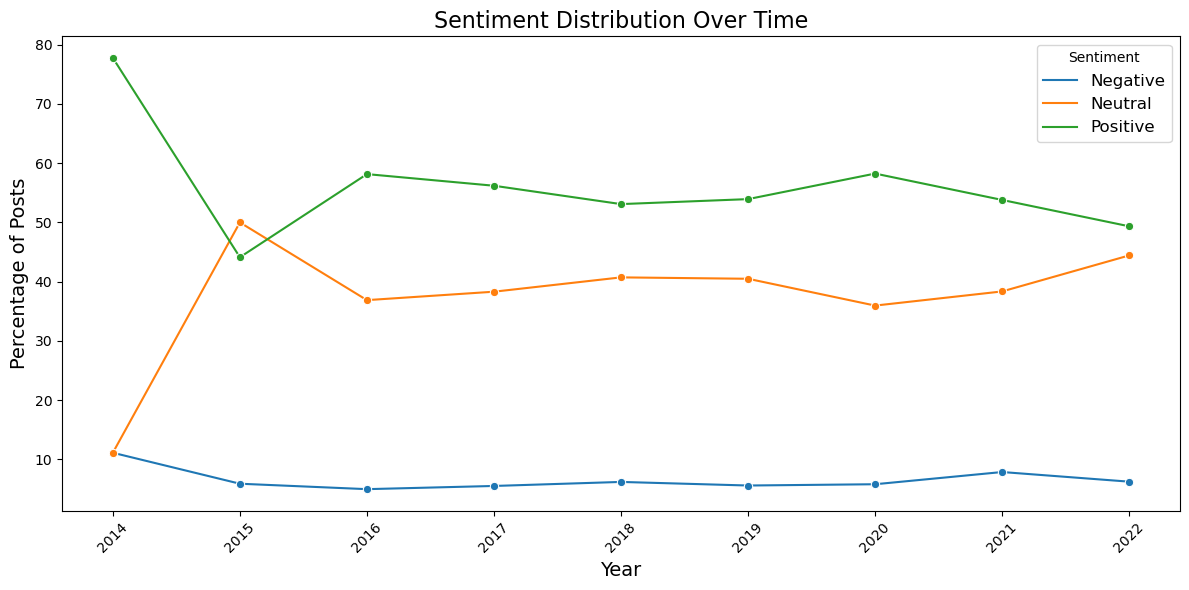

In [59]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_sentiment(text):
    """
    Analyzes the sentiment of a given text using TextBlob.
    Returns Positive, Negative, or Neutral based on polarity.
    """
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return 'Positive'
    elif polarity < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

def assign_sentiments(df):
    """
    Assign sentiment labels to the posts in the DataFrame.
    """
    df['sentiment'] = df['selftext'].apply(analyze_sentiment)
    return df

def calculate_sentiment_distribution(df):
    """
    Groups posts by year and sentiment and calculates sentiment percentages per year.
    """
    # Extract year
    df['year'] = df['created_datetime'].dt.year
    
    # Count posts per sentiment per year
    sentiment_counts = df.groupby(['year', 'sentiment']).size().reset_index(name='count')
    
    # Total posts per year
    total_per_year = df.groupby('year').size().reset_index(name='total')
    
    # Merge counts with totals
    sentiment_distribution = pd.merge(sentiment_counts, total_per_year, on='year')
    
    # Calculate percentage
    sentiment_distribution['percentage'] = (
        sentiment_distribution['count'] / sentiment_distribution['total'] * 100
    )
    
    return sentiment_distribution

def plot_sentiment_distribution(sentiment_distribution):
    """
    Plots the sentiment distribution over time.
    """
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=sentiment_distribution,
        x='year', y='percentage', hue='sentiment', marker='o'
    )
    plt.title('Sentiment Distribution Over Time', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Percentage of Posts', fontsize=14)
    plt.legend(title='Sentiment', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def sentiment_analysis_pipeline(submissions_df):
    """
    Full pipeline to analyze sentiment and plot distribution over time.
    """
    # Step 1: Assign sentiment to posts
    submissions_with_sentiment = assign_sentiments(submissions_df)
    
    # Step 2: Calculate sentiment distribution
    sentiment_distribution = calculate_sentiment_distribution(submissions_with_sentiment)
    
    # Step 3: Plot the sentiment distribution
    plot_sentiment_distribution(sentiment_distribution)

    return submissions_with_sentiment, sentiment_distribution

# Example Usage
if __name__ == "__main__":
    # Assuming `filtered_submissions` is the DataFrame from earlier
    sentiment_results, sentiment_distribution = sentiment_analysis_pipeline(result_df)


# Use Case 2: Cluster of meaningful topics (on all posts) & Highlight of new trends/spikes of interest
### Preprocess the Text Data:
- Tokenize, remove stopwords, normalize, and lemmatize the text.
### Perform Topic Modeling with LDA:
- Use Latent Dirichlet Allocation (LDA) to identify topics.
### Visualize Topics:
- Create a heatmap or bar chart showing topic distributions over time.
### Detect Trends:
- Analyze topic frequency over time and identify spikes in recent periods.
### Highlight Trending Topics:
- Use statistical techniques to compare recent trends with historical patterns.

In [60]:
df = result_df.copy()

# Functions to call the Use Case 2

In [66]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple

# Ensure NLTK resources are downloaded
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


def preprocess_text(text: str) -> str:
    """
    Preprocesses the given text by lowercasing, removing special characters, 
    tokenizing, removing stopwords, and lemmatizing.

    Args:
        text (str): The input text to preprocess.

    Returns:
        str: Preprocessed text.
    """
    # Lowercase the text
    text = text.lower()
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)


def perform_lda(
    text_data: pd.Series, 
    n_topics: int = 5, 
    max_features: int = 5000
) -> Tuple[LatentDirichletAllocation, CountVectorizer, np.ndarray]:
    """
    Performs LDA topic modeling on the provided text data.

    Args:
        text_data (pd.Series): A pandas Series of text data to analyze.
        n_topics (int): Number of topics to generate.
        max_features (int): Maximum number of features for vectorization.

    Returns:
        Tuple: LDA model, CountVectorizer, and topic assignments.
    """
    vectorizer = CountVectorizer(max_features=max_features, stop_words='english')
    text_matrix = vectorizer.fit_transform(text_data)

    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(text_matrix)

    return lda, vectorizer, lda.transform(text_matrix)


def display_topics(lda: LatentDirichletAllocation, feature_names: List[str], n_top_words: int = 10) -> Dict[str, List[str]]:
    """
    Extracts and displays the top words for each topic from the LDA model.

    Args:
        lda (LatentDirichletAllocation): Fitted LDA model.
        feature_names (List[str]): List of feature names from vectorization.
        n_top_words (int): Number of words to display for each topic.

    Returns:
        Dict[str, List[str]]: A dictionary of topics and their top words.
    """
    topics = {}
    for topic_idx, topic in enumerate(lda.components_):
        topics[f"Topic {topic_idx + 1}"] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    return topics


def analyze_topics_over_time(
    df: pd.DataFrame, 
    topic_assignments: np.ndarray
) -> pd.DataFrame:
    """
    Analyzes topic trends over time by calculating the number of posts per topic per year.

    Args:
        df (pd.DataFrame): DataFrame containing the original data with a 'created_datetime' column.
        topic_assignments (np.ndarray): Topic assignments for each post.

    Returns:
        pd.DataFrame: Topic trends over time.
    """
    df['dominant_topic'] = topic_assignments.argmax(axis=1) + 1  # Add 1 for 1-based indexing
    df['year'] = df['created_datetime'].dt.year

    # Count posts per topic per year
    topic_trends = df.groupby(['year', 'dominant_topic']).size().unstack(fill_value=0)

    return topic_trends


def detect_spikes(
    topic_trends: pd.DataFrame, 
    overall_trends: pd.Series
) -> pd.DataFrame:
    """
    Detects spikes in topic popularity relative to the overall number of posts.

    Args:
        topic_trends (pd.DataFrame): Trends of topics over time.
        overall_trends (pd.Series): Overall number of posts per year.

    Returns:
        pd.DataFrame: DataFrame of percentage changes (spikes).
    """
    # Normalize by overall number of posts
    normalized_trends = topic_trends.div(overall_trends, axis=0).fillna(0)
    percentage_change = normalized_trends.pct_change().fillna(0)

    # Highlight spikes (e.g., >50% growth)
    return percentage_change[percentage_change > 0.5]


def plot_trends(topic_trends: pd.DataFrame) -> None:
    """
    Plots topic trends over time.

    Args:
        topic_trends (pd.DataFrame): Trends of topics over time.
    """
    plt.figure(figsize=(12, 6))
    topic_trends.plot(kind='line', marker='o', colormap='tab10', figsize=(12, 6))
    plt.title('Topic Trends Over Time', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Number of Posts', fontsize=14)
    plt.legend(title='Topics', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_spikes(spikes: pd.DataFrame) -> None:
    """
    Plots a heatmap of spikes in topic popularity.

    Args:
        spikes (pd.DataFrame): DataFrame of percentage changes (spikes).
    """
    plt.figure(figsize=(12, 6))
    sns.heatmap(spikes, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
    plt.title("Spikes in Topic Popularity (Percentage Change)", fontsize=16)
    plt.xlabel("Topic", fontsize=14)
    plt.ylabel("Year", fontsize=14)
    plt.tight_layout()
    plt.show()


# Pipeline function
def topic_modeling_pipeline(
    df: pd.DataFrame, 
    n_topics: int = 5, 
    max_features: int = 5000, 
    n_top_words: int = 10
) -> None:
    """
    Executes the entire pipeline: preprocessing, topic modeling, trend analysis, and visualization.

    Args:
        df (pd.DataFrame): The input DataFrame with posts.
        n_topics (int): Number of topics for LDA.
        max_features (int): Maximum features for vectorization.
        n_top_words (int): Number of top words to display per topic.
    """
    # Preprocess text
    df['cleaned_text'] = df['selftext'].apply(preprocess_text)

    # Perform LDA
    lda, vectorizer, topic_assignments = perform_lda(df['cleaned_text'], n_topics, max_features)

    # Display topics
    topics = display_topics(lda, vectorizer.get_feature_names_out(), n_top_words)
    print("Identified Topics:")
    for topic, words in topics.items():
        print(f"{topic}: {', '.join(words)}")

    # Analyze trends over time
    topic_trends = analyze_topics_over_time(df, topic_assignments)

    # Plot topic trends
    plot_trends(topic_trends)

    # Detect and plot spikes
    overall_trends = df.groupby('year').size()
    spikes = detect_spikes(topic_trends, overall_trends)
    print("Detected Spikes in Topics:")
    print(spikes)
    plot_spikes(spikes)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jakobkuemmerle/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jakobkuemmerle/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jakobkuemmerle/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Identified Topics:
Topic 1: student, college, school, admission, application, northwestern, university, essay, year, applicant
Topic 2: school, im, northwestern, like, got, know, really, dont, want, good
Topic 3: school, year, im, ap, college, class, gpa, major, sat, northwestern
Topic 4: university, college, stanford, harvard, school, duke, state, columbia, princeton, yale
Topic 5: school, people, interview, say, like, dont, college, student, really, make


<Figure size 1200x600 with 0 Axes>

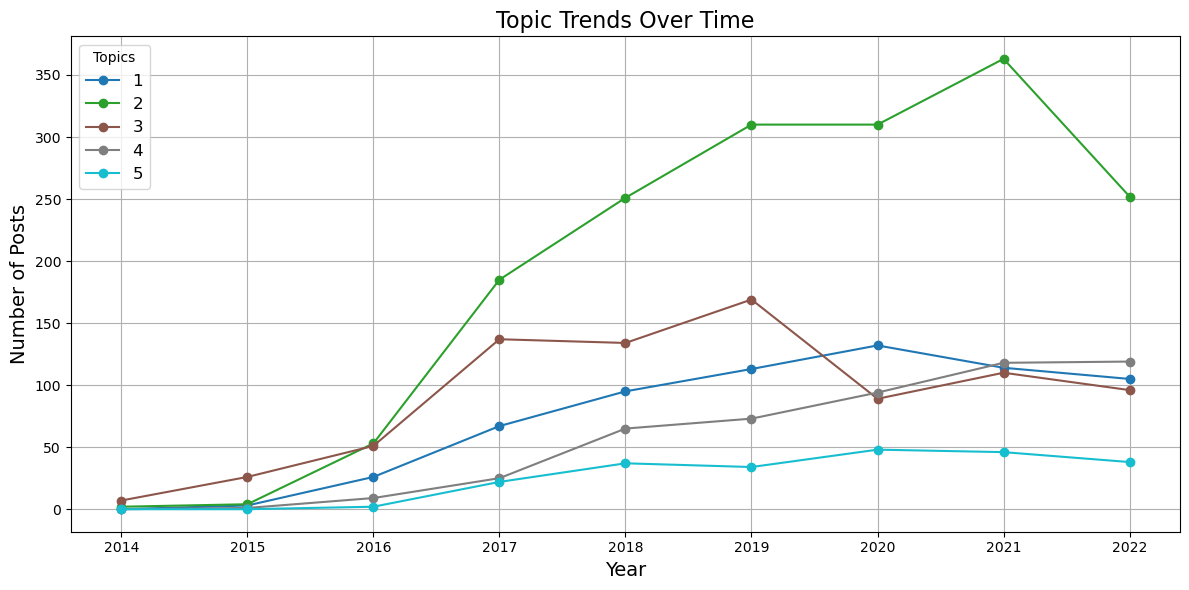

Detected Spikes in Topics:
dominant_topic         1         2   3         4         5
year                                                      
2014                 NaN       NaN NaN       NaN       NaN
2015                 inf       NaN NaN       inf       NaN
2016            1.089835  2.195035 NaN  1.170213       inf
2017                 NaN       NaN NaN       NaN  2.557339
2018                 NaN       NaN NaN  0.947766       NaN
2019                 NaN       NaN NaN       NaN       NaN
2020                 NaN       NaN NaN       NaN       NaN
2021                 NaN       NaN NaN       NaN       NaN
2022                 NaN       NaN NaN       NaN       NaN


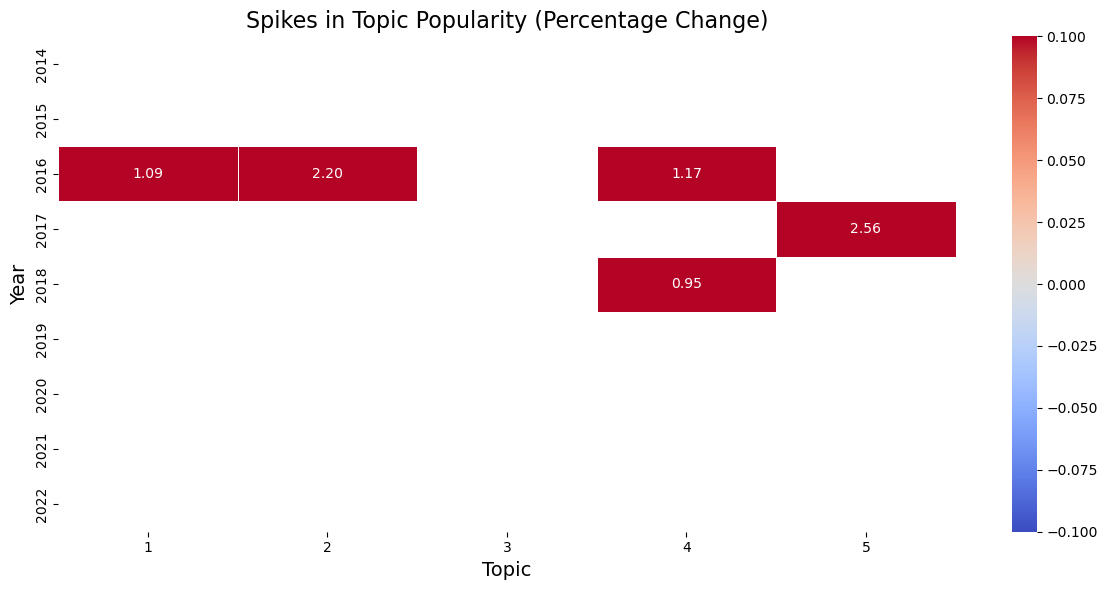

In [67]:
topic_modeling_pipeline(df)